In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from helper_functions import *

# Analysis

In [2]:
raw_data = pd.read_csv("./data/dataset.txt",sep=" ",index_col=False)
raw_data=raw_data[raw_data["pz_positron"]>0] 
number_events = raw_data["x_scattering"].shape[0]
raw_data

,x_scattering,y_scattering,z_scattering,px_mu1,py_mu1,pz_mu1,px_mu2,py_mu2,pz_mu2,px_positron,py_positron,pz_positron
0,0.006700,-0.000174,0.013579,0.026168,0.005782,27.3669,-0.026168,-0.005782,20.2281,0,0,47.5950
1,-0.001808,0.005898,0.000123,0.029397,-0.004837,19.3068,-0.029397,0.004837,30.3273,0,0,49.6341
2,0.001924,-0.004531,0.010167,0.001136,-0.023830,28.3075,-0.001136,0.023830,19.3267,0,0,47.6342
3,0.007570,0.004268,0.008222,-0.002160,-0.011196,17.4952,0.002160,0.011196,30.0357,0,0,47.5309
4,0.004862,-0.005216,0.011934,0.031203,0.005236,21.6927,-0.031203,-0.005236,26.3991,0,0,48.0918
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.002064,-0.006667,0.024110,0.013418,0.010555,26.1718,-0.013418,-0.010555,19.6198,0,0,45.7916
999996,-0.001824,-0.001494,0.026105,0.003372,0.019434,25.1396,-0.003372,-0.019434,20.5562,0,0,45.6958
999997,0.002128,-0.000650,0.028801,0.009716,0.008148,21.7877,-0.009716,-0.008148,22.5688,0,0,44.3564
999998,-0.000129,-0.003546,0.014003,-0.017934,0.020388,19.8603,0.017934,-0.020388,28.1794,0,0,48.0397


In [3]:
# here we rename all the columns to use an easy notation x y z
R_scattering = raw_data[['x_scattering', 'y_scattering', 'z_scattering']].rename(columns={'x_scattering': 'x', 'y_scattering': 'y', 'z_scattering': 'z'})
P_e = raw_data[['px_positron', 'py_positron', 'pz_positron']].rename(columns={'px_positron': 'x', 'py_positron': 'y', 'pz_positron': 'z'})
P_mu = raw_data[['px_mu1', 'py_mu1', 'pz_mu1']].rename(columns={'px_mu1': 'x', 'py_mu1': 'y', 'pz_mu1': 'z'})
P_anti_mu = raw_data[['px_mu2', 'py_mu2', 'pz_mu2']].rename(columns={'px_mu2': 'x', 'py_mu2': 'y', 'pz_mu2': 'z'})

# Detectors for positrons

In [4]:
z_positron_detectors = np.array([-0.30, -0.15]) # z of the silicon trackers before berillium target (we're traking positrons here)

r_upstream_detectors = {}
for z_new in z_positron_detectors:
    r_upstream_detectors[z_new]=R_scattering.copy()
    r_upstream_detectors[z_new]["z"]=np.ones(number_events)*z_new

Assuming square pixels of size 200.0x200.0 μm and a tolerance of 1.05 %
for detector at z=-0.3 m we choose a length of 0.022 m along x and 0.022 m along y
for detector at z=-0.15 m we choose a length of 0.022 m along x and 0.022 m along y


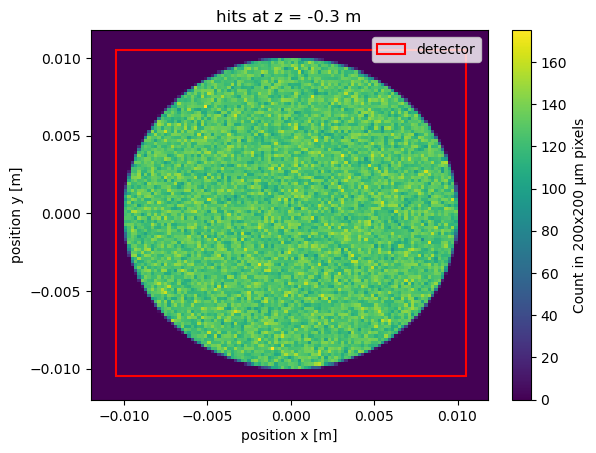

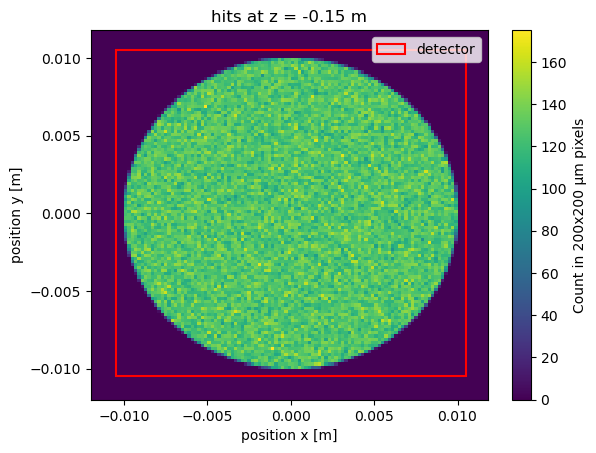

In [5]:
pixel_length = 200e-6 #m
tolerance = 1.05 #%
print("Assuming square pixels of size {}x{} μm and a tolerance of {} %".format(pixel_length*1e6,pixel_length*1e6, tolerance))
for z_pos, data in  r_upstream_detectors.items():
    # create hits map
    fig, ax = plt.subplots(1,1)
    hist = ax.hist2d(data["x"],data["y"],bins=get_edges(data,pixel_length), cmap = "viridis")
    cbar = fig.colorbar(hist[3], ax=ax, cmap="viridis")
    pixel_length_label = round(pixel_length*1e6)
    cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
    ax.set_xlabel("position x [m]")
    ax.set_ylabel("position y [m]")
    ax.set_title("hits at z = {} m".format(data["z"][0]))

    place_detector_on_hitsmap(data,tolerance,ax)

## detector pre-target recap TODO

In [6]:
z_downstream_muons_detectors = np.array([5, 6, 7])

r_downstream__muons_detectors = {}
for z_new in z_downstream_muons_detectors:
    R_mu_tmp = propagate_particles(R_scattering,P_mu,z_new,muon_mass)
    R_anti_mu_tmp = propagate_particles(R_scattering,P_anti_mu,z_new,muon_mass)
    data_tmp = {"p": R_mu_tmp.copy(), "n": R_anti_mu_tmp.copy()}
    r_downstream__muons_detectors[z_new]=data_tmp

Assuming square pixels of size 50.0x50.0 μm and a tolerance of 1.05 %:

for detector at z=5.0 m we choose a length of 0.0397 m along x and 0.0402 m along y
in this case we canẗ distinguish only 0.0013% of the pairs

for detector at z=6.000000000000001 m we choose a length of 0.0433 m along x and 0.0439 m along y
in this case we canẗ distinguish only 0.0012% of the pairs

for detector at z=7.0 m we choose a length of 0.0469 m along x and 0.0476 m along y
in this case we canẗ distinguish only 0.0009% of the pairs



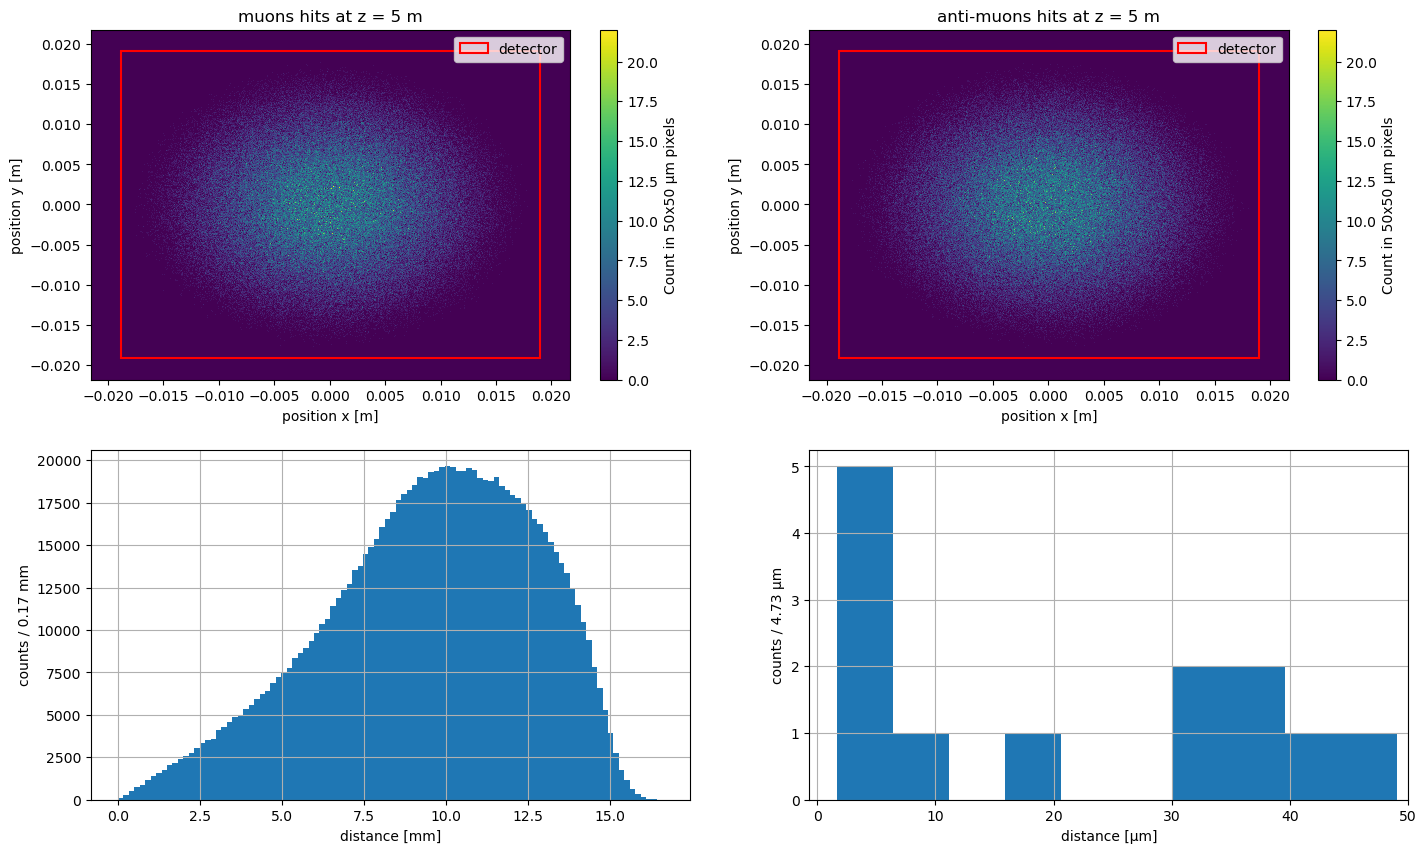

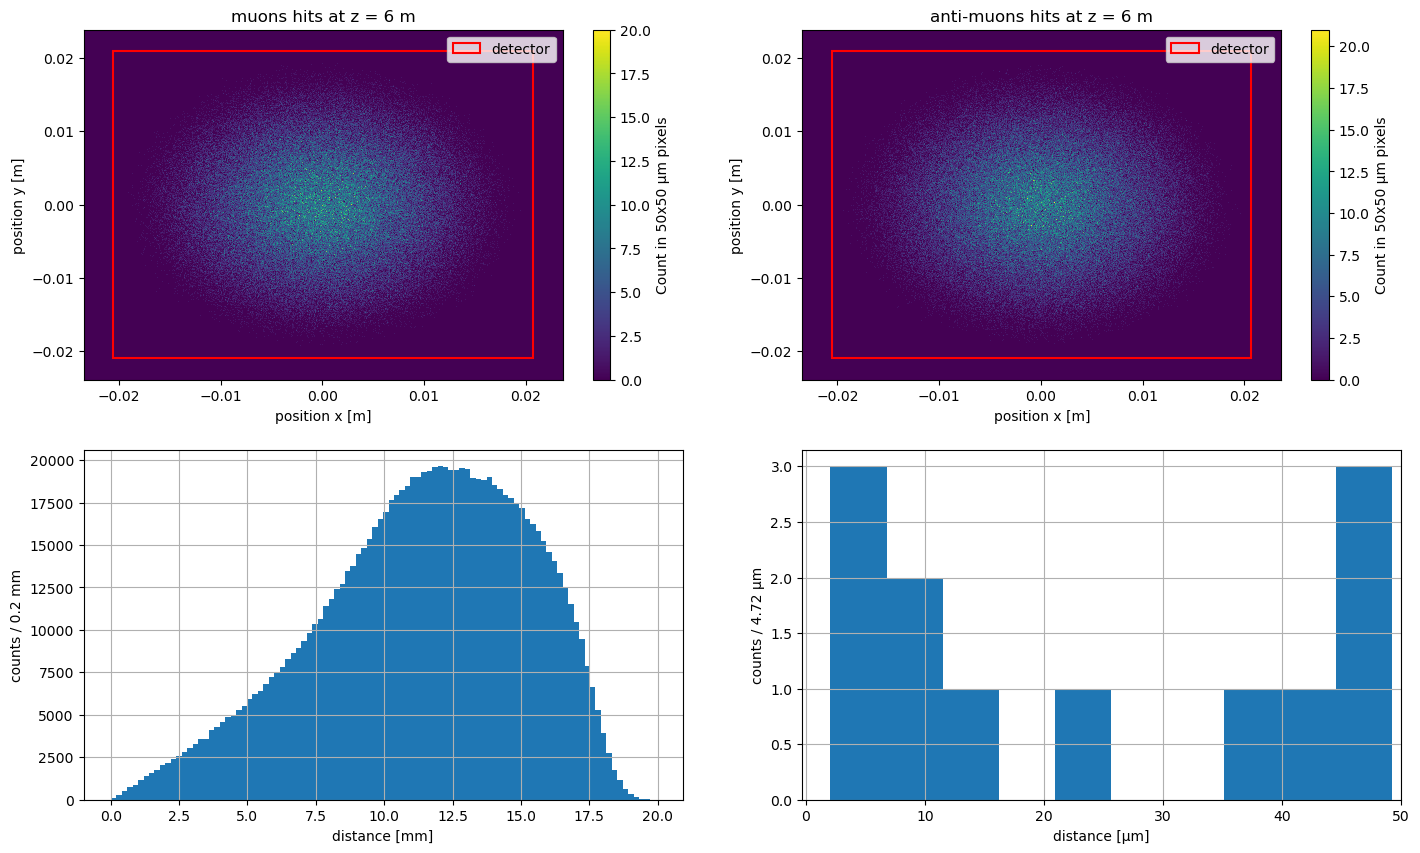

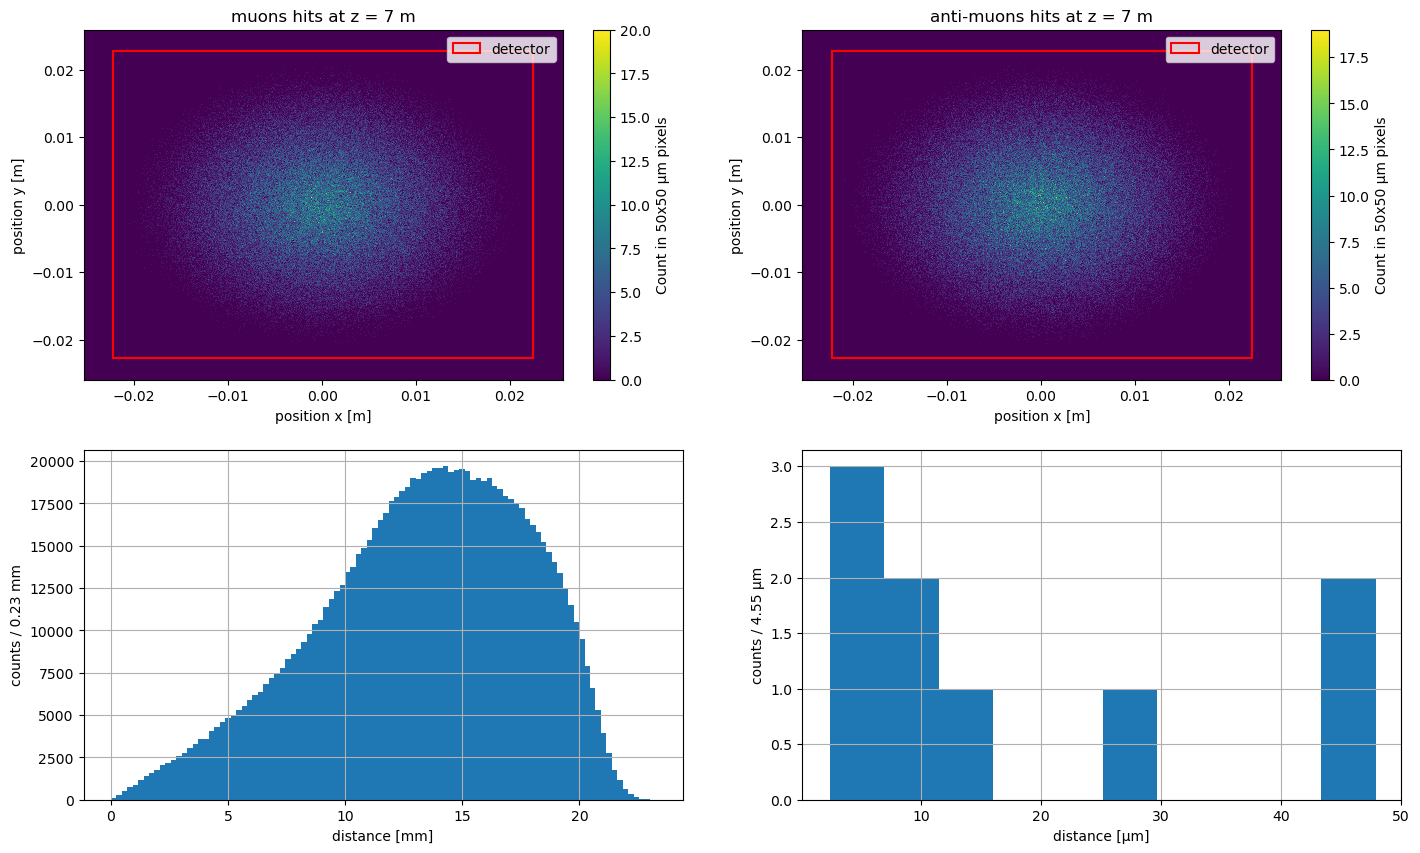

In [7]:
pixel_length = 50e-6 #m
tolerance = 1.05 #%
print("Assuming square pixels of size {}x{} μm and a tolerance of {} %:\n".format(pixel_length*1e6,pixel_length*1e6, tolerance))



for z_new, data_dic in  r_downstream__muons_detectors.items():
    # create hits map
    total_dataset = pd.concat(data_dic.values(),ignore_index=True)
    edges = get_edges(total_dataset,pixel_length)
    
    fig, ax = plt.subplots(2,2, figsize = (17,10) )
    hist_muons_p = ax[0,0].hist2d(data_dic["p"]["x"],data_dic["p"]["y"],bins=edges, cmap = "viridis")
    hist_muons_n = ax[0,1].hist2d(data_dic["n"]["x"],data_dic["n"]["y"],bins=edges, cmap = "viridis")

    df_dist = (data_dic["p"]-data_dic["n"])
    abs_dist = np.sqrt(df_dist["x"]**2 + df_dist["y"]**2 )
    abs_dist_small = abs_dist[abs_dist < pixel_length]

    abs_dist=abs_dist*1e3
    abs_dist_small=abs_dist_small*1e6
    
    hist_dist = ax[1,0].hist(abs_dist,bins=100)
    hist_dist_lost = ax[1,1].hist(abs_dist_small,bins=10)
    ax[1,1].set_xlim(right = pixel_length*1e6)
    
    histograms_2d = [hist_muons_p, hist_muons_n]
    labels = ["muons", "anti-muons"]
    
    for a, hist, label in zip(ax[0],histograms_2d, labels):
        cbar = fig.colorbar(hist[3], ax=a, cmap="viridis")
        pixel_length_label = round(pixel_length*1e6)
        cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
        a.set_xlabel("position x [m]")
        a.set_ylabel("position y [m]")
        a.set_title("{} hits at z = {} m".format(label, z_new))
        place_detector_on_hitsmap(total_dataset,tolerance,a,verbose=True if label == labels[0] else False)

    ax[1,0].set_xlabel("distance [mm]")
    ax[1,1].set_xlabel("distance [μm]")
    
    ax[1,0].grid(True)
    ax[1,1].grid(True)

    ax[1,0].set_ylabel("counts / {} mm".format(round(hist_dist[1][1]-hist_dist[1][0],2)))
    ax[1,1].set_ylabel("counts / {} μm".format(round(hist_dist_lost[1][1]-hist_dist_lost[1][0],2)))

    fraction_pair_lost = round(np.sum(hist_dist_lost[0])*100/np.sum(hist_dist[0]),6)
    print("in this case we canẗ distinguish only {}% of the pairs\n".format(fraction_pair_lost))    
    